In [1]:
import tensorflow as tf
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving reference_v.csv to reference_v.csv
Saving reference_u.csv to reference_u.csv


In [35]:
#@title Control Panel
import tensorflow as tf
import numpy as np

Re = tf.constant(100, dtype=tf.float32)
# M1: APC off (Adaptive Penalization Coefficient)
# M2: APC On
Mode_1 = 'M1' # M1 or M2

# beta: Severity of APC
# beta = 0.9 very high severity
# beta = 0.1 very low severity
beta = 0.1
adaptive_constant_bcs_val = np.array(1.0)

# N1: Encoders off
# N2: Encoders on
Mode_2 = 'N2' # N1 or N2

# Network Architectures
#layers = [2, 40, 40, 40, 40, 40, 2]
layers1 = [2, 40, 40, 40, 40, 40, 2]
layers2 = [2, 40, 40, 40, 40, 40, 2]
layers3 = [2, 40, 40, 40, 40, 40, 2]
layers4 = [2, 40, 40, 40, 40, 40, 2]
#Set number of iterations
N_ep = 12000

In [36]:
#@title Data Samplers

class Sampler:
  # Initialize the class
  def __init__(self, dim, coords, func):

    self.dim = dim
    self.coords = coords
    self.func = func

  def sample(self, N):
    x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
    y = self.func(x)
    return x, y

In [37]:
#@title BC & IC Functions
def U_gamma_1(x):
  num = x.shape[0]
  return np.tile(np.array([1.0, 0.0]), (num, 1))


def U_gamma_2(x):
  num = x.shape[0]
  return np.zeros((num, 2))


def f(x):
  num = x.shape[0]
  return np.zeros((num, 2))

In [38]:
#@title Data Generation - REGULAR PINN
# Parameters of equations
Re = tf.constant(100, dtype=tf.float32)

# Domain boundaries (lb and ub)
bc1_coords = np.array([[0.0, 1.0], [1.0, 1.0]])
bc2_coords = np.array([[0.0, 0.0], [0.0, 1.0]])
bc3_coords = np.array([[1.0, 0.0], [1.0, 1.0]])
bc4_coords = np.array([[0.0, 0.0], [1.0, 0.0]])
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])


bc1 = Sampler(2, bc1_coords, lambda x: U_gamma_1(x))
bc2 = Sampler(2, bc2_coords, lambda x: U_gamma_2(x))
bc3 = Sampler(2, bc3_coords, lambda x: U_gamma_2(x))
bc4 = Sampler(2, bc4_coords, lambda x: U_gamma_2(x))
bcs_sampler = [bc1, bc2, bc3, bc4]
res_sampler = Sampler(2, dom_coords, lambda x: f(x))

# N_b: number of BC for each boundary
# N_r: number of residual points
N_b = 50
N_r = 2000

X, _ = res_sampler.sample(np.int32(N_r))
mu_X, sigma_X = X.mean(0), X.std(0)
mu_x, sigma_x = mu_X[0], sigma_X[0]
mu_y, sigma_y = mu_X[1], sigma_X[1]

def fetch_minibatch(sampler, N):
  X, Y = sampler.sample(N)
  #X = (X - mu_X) / sigma_X
  return X, Y


X_bc1, u_bc1 = fetch_minibatch(bcs_sampler[0], N_b) # up
X_bc2, u_bc2 = fetch_minibatch(bcs_sampler[1], N_b) # left
X_bc3, u_bc3 = fetch_minibatch(bcs_sampler[2], N_b) # right
X_bc4, u_bc4 = fetch_minibatch(bcs_sampler[3], N_b) # buttom

'''X_bc1 = tf.convert_to_tensor(X_bc1, dtype = tf.float32)
X_bc2 = tf.convert_to_tensor(X_bc2, dtype = tf.float32)
X_bc3 = tf.convert_to_tensor(X_bc3, dtype = tf.float32)
X_bc4 = tf.convert_to_tensor(X_bc4, dtype = tf.float32)'''

X_bcs = [X_bc1, X_bc2, X_bc3, X_bc4]
U_bcs = [u_bc1, u_bc2, u_bc3, u_bc4]


Domain = np.concatenate((X_bc1, X_bc2, X_bc3, X_bc4))
lb = Domain.min(0)
ub = Domain.max(0)

#U_bc1 = tf.convert_to_tensor(u_bc1, dtype = tf.float32)
#X_bcs = tf.convert_to_tensor(np.concatenate((X_bc1, X_bc2, X_bc3, X_bc4)), dtype = tf.float32)
#U_bcs = tf.convert_to_tensor(np.concatenate((u_bc1, u_bc2, u_bc3, u_bc4)), dtype = tf.float32)

X_res, _ = tf.convert_to_tensor(fetch_minibatch(res_sampler, N_r), dtype = tf.float32)

# Lower bounds
lb = tf.constant([0., 0.], dtype='float32')
# Upper bounds
ub = tf.constant([1., 1.], dtype='float32')


'plt.scatter(bc1_coords[:,0], bc1_coords[:,1])\nplt.scatter(bc2_coords[:,0], bc2_coords[:,1])\nplt.scatter(bc3_coords[:,0], bc3_coords[:,1])\nplt.scatter(bc4_coords[:,0], bc4_coords[:,1])'

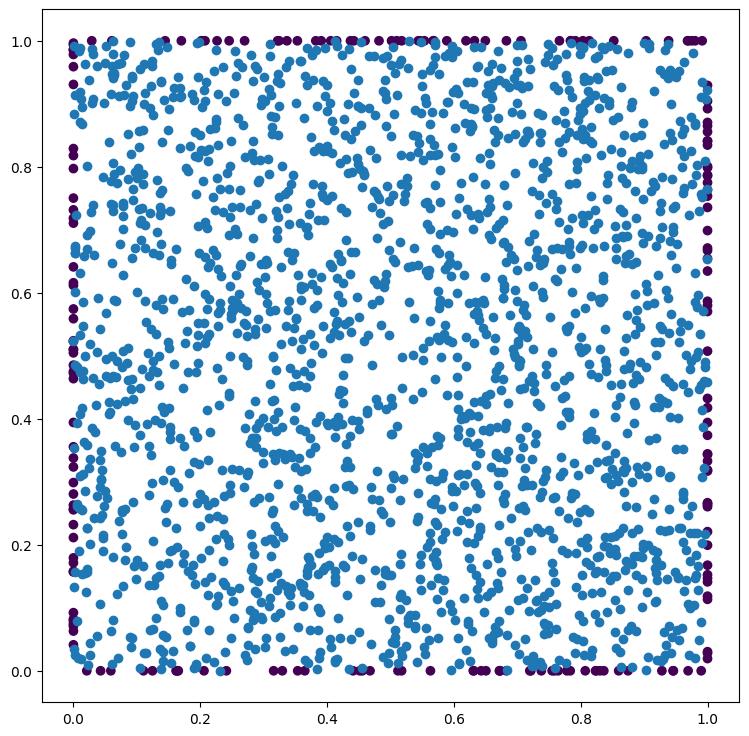

In [39]:
#@title Domain and Data Plot
import matplotlib.pyplot as plt

fig_1 = plt.figure(figsize=(9,9))

#plt.scatter(u_bc1[:,0], X_bc1[:,0], c='b', marker='x')

#plt.scatter(X_bc1[:,0:1], X_bc1[:,1:2], c= SDF1 * u_bc1[:,0:1])
plt.scatter(X_bc1[:,0:1], X_bc1[:,1:2], c= u_bc1[:,0:1])
plt.scatter(X_bc2[:,0:1], X_bc2[:,1:2], c= u_bc2[:,0:1])
plt.scatter(X_bc3[:,0:1], X_bc3[:,1:2], c= u_bc3[:,0:1])
plt.scatter(X_bc4[:,0:1], X_bc4[:,1:2], c= u_bc4[:,0:1])
plt.scatter(X_res[:,0:1], X_res[:,1:2])
#plt.scatter(X_res[:,0:1], X_res[:,1:2], c = SW)

'''def f(x):
   return 0.75 +  (x - 0.5)**2
   #return  0.6 + 6.5 * (x - 0.5)**4
   #return 0.5 + tf.abs(x - 0.5)
x = np.linspace(0, 1, 100)

plt.plot(x, f(x), color='red')'''


'''plt.scatter(X_bcs[:,0:1], X_bcs[:,1:2], c= U_bcs[:,0])
plt.scatter(X_res[:,0:1], X_res[:,1:2])'''

'''plt.scatter(bc1_coords[:,0], bc1_coords[:,1])
plt.scatter(bc2_coords[:,0], bc2_coords[:,1])
plt.scatter(bc3_coords[:,0], bc3_coords[:,1])
plt.scatter(bc4_coords[:,0], bc4_coords[:,1])'''

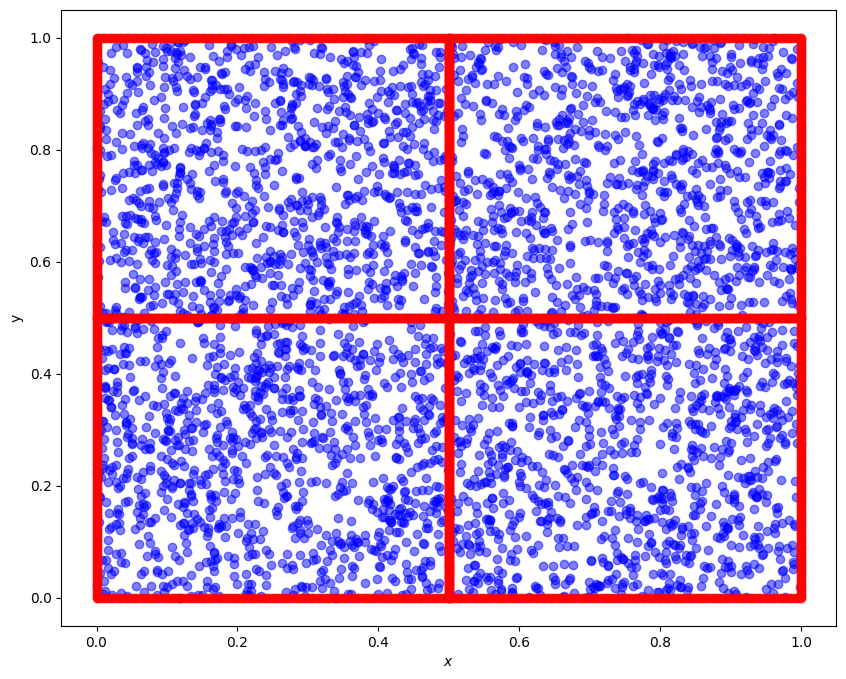

In [40]:
#@title Points Generation - DD PINN
import matplotlib.pyplot as plt
# User inputs
Nx = 2
Ny = 2
Nr = 1000
Nb = 200

# Create meshgrid for elements
x = np.linspace(0, 1, Nx + 1)
y = np.linspace(0, 1, Ny + 1)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

# Initialize arrays for points
xy_f_e = np.zeros((Nx * Ny, Nr, 2))
xy_lb_e = np.zeros((Nx * Ny, Nb, 2))
xy_rb_e = np.zeros((Nx * Ny, Nb, 2))
xy_bb_e = np.zeros((Nx * Ny, Nb, 2))
xy_ub_e = np.zeros((Nx * Ny, Nb, 2))

# Generate points on element boundaries
for i in range(Nx):
    for j in range(Ny):
        idx = i * Ny + j
        x_min = X[i]
        x_max = X[i + 1]
        y_min = Y[j * (Ny + 1)]
        y_max = Y[(j + 1) * (Ny + 1)]
        xy_lb_e[idx] = np.array([(x_min, y) for y in np.linspace(y_min, y_max, Nb)])
        xy_rb_e[idx] = np.array([(x_max, y) for y in np.linspace(y_min, y_max, Nb)])
        xy_bb_e[idx] = np.array([(x, y_min) for x in np.linspace(x_min, x_max, Nb)])
        xy_ub_e[idx] = np.array([(x, y_max) for x in np.linspace(x_min, x_max, Nb)])

        # Generate points inside each element
        xy_f_e[idx] = np.random.uniform((x_min, y_min), (x_max, y_max), (Nr, 2))
        # Shift random points that are located on element boundary
        xy_f_e[idx] += np.finfo(float).eps * np.random.randn(Nr, 2)

# Plot points
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(Nx * Ny):
    ax.scatter(xy_f_e[i, :, 0], xy_f_e[i, :, 1], color="blue", alpha=0.5)
    ax.scatter(xy_lb_e[i, :, 0], xy_lb_e[i, :, 1], color="red", alpha=0.5)
    ax.scatter(xy_rb_e[i, :, 0], xy_rb_e[i, :, 1], color="red", alpha=0.5)
    ax.scatter(xy_bb_e[i, :, 0], xy_bb_e[i, :, 1], color="red", alpha=0.5)
    ax.scatter(xy_ub_e[i, :, 0], xy_ub_e[i, :, 1], color="red", alpha=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('y');
plt.savefig('DD-PINN Domain.png', bbox_inches='tight', dpi=600)
plt.show()

xy_f_e = tf.convert_to_tensor((xy_f_e), dtype = tf.float32)

xy_lb_e= tf.convert_to_tensor((xy_lb_e), dtype = tf.float32)
xy_rb_e= tf.convert_to_tensor((xy_rb_e), dtype = tf.float32)
xy_bb_e= tf.convert_to_tensor((xy_bb_e), dtype = tf.float32)
xy_ub_e= tf.convert_to_tensor((xy_ub_e), dtype = tf.float32)

u_bc1 = np.ones((Nb, 2))
u_bc1[:, 1] = 0
u_bc2 = u_bc3 = u_bc4 = np.zeros((Nb, 2))
U_bcs = [u_bc1, u_bc2, u_bc3, u_bc4]

In [ ]:
#@title Keras Model
'''#Model

def init_model(num_hidden_layers=8, num_neurons_per_layer=30):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (x, y)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))

    return model

init_model().summary()'''

In [41]:
#@title Manual Neural Nets
# Xavier initialization
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                        dtype=tf.float32)

if Mode_2 in ['N2']:
            # Initialize encoder weights and biases
            encoder_weights_11 = xavier_init([2, layers1[1]])
            encoder_biases_11 = xavier_init([1, layers1[1]])

            encoder_weights_12 = xavier_init([2, layers1[1]])
            encoder_biases_12 = xavier_init([1, layers1[1]])

            encoder_weights_21 = xavier_init([2, layers2[1]])
            encoder_biases_21 = xavier_init([1, layers2[1]])

            encoder_weights_22 = xavier_init([2, layers2[1]])
            encoder_biases_22 = xavier_init([1, layers2[1]])

            encoder_weights_31 = xavier_init([2, layers3[1]])
            encoder_biases_31 = xavier_init([1, layers3[1]])

            encoder_weights_32 = xavier_init([2, layers3[1]])
            encoder_biases_32 = xavier_init([1, layers3[1]])

            encoder_weights_41 = xavier_init([2, layers4[1]])
            encoder_biases_41 = xavier_init([1, layers4[1]])

            encoder_weights_42 = xavier_init([2, layers4[1]])
            encoder_biases_42 = xavier_init([1, layers4[1]])

# Initialize network weights and biases using Xavier initialization
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
        W = xavier_init(size=[layers[l], layers[l + 1]])
        b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
    return weights, biases

encoder_weights_1 = [encoder_weights_11, encoder_weights_21, encoder_weights_31, encoder_weights_41]
encoder_biases_1 = [encoder_biases_11, encoder_biases_21, encoder_biases_31, encoder_biases_41]
encoder_weights_2 = [encoder_weights_12, encoder_weights_22, encoder_weights_32, encoder_weights_42]
encoder_biases_2 = [encoder_biases_12, encoder_biases_22, encoder_biases_32, encoder_biases_42]

weights1, biases1 = initialize_NN(layers1)
weights2, biases2 = initialize_NN(layers2)
weights3, biases3 = initialize_NN(layers3)
weights4, biases4 = initialize_NN(layers4)




# Evaluates the forward pass %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Network
def forward_pass(H, weights, biases, w1, b1, w2, b2):
    if Mode_2 in ['N1']:
        num_layers = len(weights) + 1
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    if Mode_2 in ['N2']:
        num_layers = len(layers1)
        encoder_1 = tf.tanh(tf.add(tf.matmul(H, w1), b1))
        encoder_2 = tf.tanh(tf.add(tf.matmul(H, w2), b2))

        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                tf.math.multiply(tf.tanh(tf.add(1 - tf.matmul(H, W), b)), encoder_2)

        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

In [42]:
#@title Def Operator
def operator(X, w, b, w1, b1, w2, b2):
    # A tf.GradientTape is used to compute derivatives in TensorFlow
  with tf.GradientTape(persistent=True) as ggg:
      x, y = X[:, 0:1], X[:,1:2]
      #x, y = x_res, y_res
      ggg.watch(x)
      ggg.watch(y)
      with tf.GradientTape(persistent=True) as gg:
          gg.watch(x)
          gg.watch(y)
          with tf.GradientTape(persistent=True) as g:
              g.watch(x)
              g.watch(y)
              psi_p = forward_pass(tf.stack([x[:,0], y[:,0]], axis=-1), w, b, w1, b1, w2, b2)
              psi = psi_p[..., 0, tf.newaxis]
              p   = psi_p[..., 1, tf.newaxis]
          u   =  g.gradient(psi, y)
          v   = -g.gradient(psi, x)
          p_x =  g.gradient(p,   x)
          p_y =  g.gradient(p,   y)
          del g
      u_x = gg.gradient(u, x)
      u_y = gg.gradient(u, y)
      v_x = gg.gradient(v, x)
      v_y = gg.gradient(v, y)
      del gg
  u_xx = ggg.gradient(u_x, x)
  u_yy = ggg.gradient(u_y, y)
  v_xx = ggg.gradient(v_x, x)
  v_yy = ggg.gradient(v_y, y)
  del ggg

  Ru_momentum = u * u_x + v * u_y + p_x - (u_xx + u_yy) / Re
  Rv_momentum = u * v_x + v * v_y + p_y - (v_xx + v_yy) / Re

  return Ru_momentum, Rv_momentum

In [43]:
#@title Output extraction from net
# Forward pass
def net_uv(X, w, b, w1, b1, w2, b2):
  Xt = tf.convert_to_tensor(X, dtype = tf.float32)
  with tf.GradientTape(persistent=True) as g:
    x, y = Xt[:, 0:1], Xt[:,1:2]
    g.watch(x)
    g.watch(y)
    psi_p = forward_pass(tf.stack([x[:,0], y[:,0]], axis=-1), w, b, w1, b1, w2, b2)
    psi = psi_p[..., 0, tf.newaxis]
    p   = psi_p[..., 1, tf.newaxis]
  u   =  g.gradient(psi, y)
  v   = -g.gradient(psi, x)
  px =  g.gradient(p,   x)
  py =  g.gradient(p,   y)
  #SDF_comp = 1 - 2 * tf.abs(x-0.5) #SDF-1
  #SDF_comp = 1 - 4 * (x-0.5)**2  #SDF-2
  #SDF_comp = 1 + 4 * (x-0.5)**2  # ISDF-2
  #SDF_comp = 1 + 2 * tf.abs(x-0.5)  # ISDF-1

  del g
  return u, v, psi, p, psi_p, px, py

In [44]:
# Loss_res terms computations
Ws = [weights1, weights2, weights3, weights4]
Bs = [biases1, biases2, biases3, biases4]
def compute_loss():
  Ru_e = []
  Rv_e = []
  Ru = []
  Rv = []
  f_lb_x = []
  f_lb_y = []
  f_rb_x = []
  f_rb_y = []
  f_bb_x = []
  f_bb_y = []
  f_ub_x = []
  f_ub_y = []
  f_lb_x_e = []
  f_lb_y_e = []
  f_rb_x_e = []
  f_rb_y_e = []
  f_bb_x_e = []
  f_bb_y_e = []
  f_ub_x_e = []
  f_ub_y_e = []

  #Ws = [weights1, weights2, weights3, weights4, weights2]
  #Bs = [biases1, biases2, biases3, biases4, biases2]

  for i in range(len(xy_f_e)):
    # for loss f
    Ru_e, Rv_e = operator(xy_f_e[i], Ws[i], Bs[i], encoder_weights_1[i], encoder_biases_1[i], encoder_weights_2[i], encoder_biases_2[i])
    Ru.append(Ru_e)
    Rv.append(Rv_e)
    # for loss interface (R)
    f_lb_x_e, f_lb_y_e = operator(xy_lb_e[i], Ws[i], Bs[i], encoder_weights_1[i], encoder_biases_1[i], encoder_weights_2[i], encoder_biases_2[i])
    f_lb_x.append(f_lb_x_e)
    f_lb_y.append(f_lb_y_e)

    f_rb_x_e, f_rb_y_e = operator(xy_rb_e[i], Ws[i], Bs[i], encoder_weights_1[i], encoder_biases_1[i], encoder_weights_2[i], encoder_biases_2[i])
    f_rb_x.append(f_rb_x_e)
    f_rb_y.append(f_rb_y_e)

    f_bb_x_e, f_bb_y_e = operator(xy_bb_e[i], Ws[i], Bs[i], encoder_weights_1[i], encoder_biases_1[i], encoder_weights_2[i], encoder_biases_2[i])
    f_bb_x.append(f_bb_x_e)
    f_bb_y.append(f_bb_y_e)

    f_ub_x_e, f_ub_y_e = operator(xy_ub_e[i], Ws[i], Bs[i], encoder_weights_1[i], encoder_biases_1[i], encoder_weights_2[i], encoder_biases_2[i])
    f_ub_x.append(f_ub_x_e)
    f_ub_y.append(f_ub_y_e)

    # for loss velocity
    # to be added...
  u11, v11, psi11, p11, psi_p11, px11, py11 = net_uv(xy_bb_e[0], weights1, biases1, encoder_weights_1[0], encoder_biases_1[0], encoder_weights_2[0], encoder_biases_2[0])
  u_pred_11 = tf.concat([u11, v11], axis=-1)
  dp11 = tf.concat([px11, py11], axis = -1)

  u12, v12, psi12, p12, psi_p12, px12, py12 = net_uv(xy_lb_e[0], weights1, biases1, encoder_weights_1[0], encoder_biases_1[0], encoder_weights_2[0], encoder_biases_2[0])
  u_pred_12 = tf.concat([u12, v12], axis=-1)
  dp12 = tf.concat([px12, py12], axis = -1)

  u13, v13, psi13, p13, psi_p13, px13, py13 = net_uv(xy_ub_e[0], weights1, biases1, encoder_weights_1[0], encoder_biases_1[0], encoder_weights_2[0], encoder_biases_2[0])
  u_pred_13 = tf.concat([u13, v13], axis=-1)
  dp13 = tf.concat([px13, py13], axis = -1)

  u14, v14, psi14, p14, psi_p14, px14, py14 = net_uv(xy_rb_e[0], weights1, biases1, encoder_weights_1[0], encoder_biases_1[0], encoder_weights_2[0], encoder_biases_2[0])
  u_pred_14 = tf.concat([u14, v14], axis=-1)
  dp14 = tf.concat([px14, py14], axis = -1)

  u21, v21, psi21, p21, psi_p21, px21, py21 = net_uv(xy_ub_e[1], weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])
  u_pred_21 = tf.concat([u21, v21], axis=-1)
  dp21 = tf.concat([px21, py21], axis = -1)

  u22, v22, psi22, p22, psi_p22, px22, py22 = net_uv(xy_lb_e[1], weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])
  u_pred_22 = tf.concat([u22, v22], axis=-1)
  dp22 = tf.concat([px22, py22], axis = -1)

  u23, v23, psi23, p23, psi_p23, px23, py23 = net_uv(xy_bb_e[1], weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])
  u_pred_23 = tf.concat([u23, v23], axis=-1)
  dp23 = tf.concat([px23, py23], axis = -1)

  u24, v24, psi24, p24, psi_p24, px24, py24 = net_uv(xy_rb_e[1], weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])
  u_pred_24 = tf.concat([u24, v24], axis=-1)
  dp24 = tf.concat([px24, py24], axis = -1)

  u31, v31, psi31, p31, psi_p31, px31, py31 = net_uv(xy_bb_e[2], weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])
  u_pred_31 = tf.concat([u31, v31], axis=-1)
  dp31 = tf.concat([px31, py31], axis = -1)

  u32, v32, psi32, p32, psi_p32, px32, py32 = net_uv(xy_rb_e[2], weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])
  u_pred_32 = tf.concat([u32, v32], axis=-1)
  dp32 = tf.concat([px32, py32], axis = -1)

  u33, v33, psi33, p33, psi_p33, px33, py33 = net_uv(xy_ub_e[2], weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])
  u_pred_33 = tf.concat([u33, v33], axis=-1)
  dp33 = tf.concat([px33, py33], axis = -1)

  u34, v34, psi34, p34, psi_p34, px34, py34 = net_uv(xy_lb_e[2], weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])
  u_pred_34 = tf.concat([u34, v34], axis=-1)
  dp34 = tf.concat([px34, py34], axis = -1)

  u41, v41, psi41, p41, psi_p41, px41, py41 = net_uv(xy_ub_e[3], weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])
  u_pred_41 = tf.concat([u41, v41], axis=-1)
  dp41 = tf.concat([px41, py41], axis = -1)

  u42, v42, psi42, p42, psi_p42, px42, py42 = net_uv(xy_rb_e[3], weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])
  u_pred_42 = tf.concat([u42, v42], axis=-1)
  dp42 = tf.concat([px42, py42], axis = -1)

  u43, v43, psi43, p43, psi_p43, px43, py43 = net_uv(xy_bb_e[3], weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])
  u_pred_43 = tf.concat([u43, v43], axis=-1)
  dp43 = tf.concat([px43, py43], axis = -1)

  u44, v44, psi44, p44, psi_p44, px44, py44 = net_uv(xy_lb_e[3], weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])
  u_pred_44 = tf.concat([u44, v44], axis=-1)
  dp44 = tf.concat([px44, py44], axis = -1)

  # Essential : (Res-D), (Bcs), (Phi-el), (P-el)
  # Optional  : Grad(phi-el), Grad(P-el), (Res-el)

  loss = []
  L_res = []
  L_psi_p = []
  L_U_i = []
  L_U_D = []
  L_dp = []
  for i in range(len(xy_f_e)):

    if i == 0:
      loss_res = (tf.reduce_mean(tf.square(Ru[i])) + tf.reduce_mean(tf.square(Rv[i])))
      loss_psi_p_i = (tf.reduce_mean(tf.square(psi_p13 - psi_p23)) + tf.reduce_mean(tf.square(psi_p14 - psi_p34)))
      loss_U_D = (tf.reduce_mean(tf.square(u_pred_11)) + tf.reduce_mean(tf.square(u_pred_12)))
      loss_U_i = (tf.reduce_mean(tf.square(u_pred_13 -u_pred_23)) + tf.reduce_mean(tf.square(u_pred_14 - u_pred_34)))
      loss_dp_i = (tf.reduce_mean(tf.square(dp13 - dp23)) + tf.reduce_mean(tf.square(dp14 - dp34)))
      loss_i = loss_res + loss_psi_p_i + loss_U_D + loss_U_i + loss_dp_i


    elif i == 1:
      loss_res = (tf.reduce_mean(tf.square(Ru[i])) + tf.reduce_mean(tf.square(Rv[i])))
      loss_psi_p_i = (tf.reduce_mean(tf.square(psi_p23 - psi_p13)) + tf.reduce_mean(tf.square(psi_p24 - psi_p44)))
      loss_U_D = (tf.reduce_mean(tf.square(u_pred_21 - U_bcs[0])) + tf.reduce_mean(tf.square(u_pred_22)))
      loss_U_i = (tf.reduce_mean(tf.square(u_pred_23 - u_pred_13)) + tf.reduce_mean(tf.square(u_pred_24 - u_pred_44)))
      loss_dp_i = (tf.reduce_mean(tf.square(dp23 - dp13)) + tf.reduce_mean(tf.square(dp24 - dp44)))
      loss_i = loss_res + loss_psi_p_i + loss_U_D + loss_U_i + loss_dp_i

    elif i == 2:
      loss_res = (tf.reduce_mean(tf.square(Ru[i])) + tf.reduce_mean(tf.square(Rv[i])))
      loss_psi_p_i = (tf.reduce_mean(tf.square(psi_p34 - psi_p14)) + tf.reduce_mean(tf.square(psi_p33 - psi_p43)))
      loss_U_D = (tf.reduce_mean(tf.square(u_pred_31)) + tf.reduce_mean(tf.square(u_pred_32)))
      loss_U_i = (tf.reduce_mean(tf.square(u_pred_33 - u_pred_43)) + tf.reduce_mean(tf.square(u_pred_34 - u_pred_14)))
      loss_dp_i = (tf.reduce_mean(tf.square(dp34 - dp14)) + tf.reduce_mean(tf.square(dp33 - dp43)))
      loss_i = loss_res + loss_psi_p_i + loss_U_D + loss_U_i + loss_dp_i

    elif i == 3:
      loss_res = (tf.reduce_mean(tf.square(Ru[i])) + tf.reduce_mean(tf.square(Rv[i])))
      loss_psi_p_i = (tf.reduce_mean(tf.square(psi_p44 - psi_p24)) + tf.reduce_mean(tf.square(psi_p43 - psi_p33)))
      loss_U_D = (tf.reduce_mean(tf.square(u_pred_41 - U_bcs[0])) + tf.reduce_mean(tf.square(u_pred_42)))
      loss_U_i = (tf.reduce_mean(tf.square(u_pred_43 - u_pred_33)) + tf.reduce_mean(tf.square(u_pred_44 - u_pred_24)))
      loss_dp_i = (tf.reduce_mean(tf.square(dp44 - dp24)) + tf.reduce_mean(tf.square(dp43 - dp33)))
      loss_i = loss_res + loss_psi_p_i + loss_U_D + loss_U_i + loss_dp_i

    loss.append(loss_i)
    L_res.append(loss_res)
    L_psi_p.append(loss_psi_p_i)
    L_U_i.append(loss_U_i)
    L_U_D.append(loss_U_D)
    L_dp.append(loss_dp_i)
  loss = tf.cast(loss, dtype = tf.float64)
  L_res = tf.cast(L_res, dtype = tf.float64)
  L_psi_p = tf.cast(L_psi_p, dtype = tf.float64)
  L_U_i = tf.cast(L_U_i, dtype = tf.float64)
  L_U_D = tf.cast(L_U_D, dtype = tf.float64)
  L_dp = tf.cast(L_dp, dtype = tf.float64)

  return loss, L_res, L_psi_p, L_U_i, L_U_D, L_dp

In [ ]:
#@title Default title text
# Loss_res terms computations
Ws = [weights1, weights2, weights3, weights4, weights5]
Bs = [biases1, biases2, biases3, biases4, biases5]
def compute_loss_res():
  Ru_e = []
  Rv_e = []
  Ru = []
  Rv = []
  f_lb_x = []
  f_lb_y = []
  f_rb_x = []
  f_rb_y = []
  f_bb_x = []
  f_bb_y = []
  f_ub_x = []
  f_ub_y = []
  f_lb_x_e = []
  f_lb_y_e = []
  f_rb_x_e = []
  f_rb_y_e = []
  f_bb_x_e = []
  f_bb_y_e = []
  f_ub_x_e = []
  f_ub_y_e = []


  for i in range(len(xy_f_e)):
    # for loss f
    Ru_e, Rv_e = operator(xy_f_e[i], Ws[i], Bs[i])
    Ru.append(Ru_e)
    Rv.append(Rv_e)
    # for loss interface (R)
    f_lb_x_e, f_lb_y_e = operator(xy_lb_e[i], Ws[i], Bs[i])
    f_lb_x.append(f_lb_x_e)
    f_lb_y.append(f_lb_y_e)

    f_rb_x_e, f_rb_y_e = operator(xy_rb_e[i], Ws[i], Bs[i])
    f_rb_x.append(f_rb_x_e)
    f_rb_y.append(f_rb_y_e)

    f_bb_x_e, f_bb_y_e = operator(xy_bb_e[i], Ws[i], Bs[i])
    f_bb_x.append(f_bb_x_e)
    f_bb_y.append(f_bb_y_e)

    f_ub_x_e, f_ub_y_e = operator(xy_ub_e[i], Ws[i], Bs[i])
    f_ub_x.append(f_ub_x_e)
    f_ub_y.append(f_ub_y_e)

    # for loss velocity
    # to be added...
  # Loss computations
  loss_res = []
  loss_res_c = []
  for i in range(len(xy_f_e)):
    loss = []
    if i == 0:
      loss1 = tf.reduce_mean(tf.square(Ru[i]) + tf.square(Rv[i]))

      loss2 = tf.reduce_mean(tf.square(f_rb_x[i]-f_lb_x[i + N_el_y]) + tf.square(f_rb_y[i]-f_lb_y[i + N_el_y]) + tf.square(f_ub_x[i]-f_bb_x[i + 1]) + tf.square(f_ub_y[i]-f_bb_y[i + 1]))

    elif i == 1:
      loss1 = tf.reduce_mean(tf.square(Ru[i]) + tf.square(Rv[i]))

      loss2 = tf.reduce_mean(tf.square(f_rb_x[i]-f_lb_x[i + N_el_y]) + tf.square(f_rb_y[i]-f_lb_y[i + N_el_y])
                            + tf.square(f_bb_x[i]-f_ub_x[i - 1]) + tf.square(f_bb_y[i]-f_ub_y[i - 1]))

    elif i == 2:
      loss1 = tf.reduce_mean(tf.square(Ru[i]) + tf.square(Rv[i]))
      loss2 = tf.reduce_mean(tf.square(f_lb_x[i]-f_rb_x[i - N_el_y]) + tf.square(f_lb_y[i]-f_rb_y[i - N_el_y])
                            + tf.square(f_ub_x[i]-f_bb_x[i + 1]) + tf.square(f_ub_y[i]-f_bb_y[i + 1]))

    elif i == 3:
      loss1 = tf.reduce_mean(tf.square(Ru[i]) + tf.square(Rv[i]))
      loss2 = tf.reduce_mean(tf.square(f_lb_x[i]-f_rb_x[i - N_el_y]) + tf.square(f_lb_y[i]-f_rb_y[i - N_el_y])
                            + tf.square(f_bb_x[i]-f_ub_x[i - 1]) + tf.square(f_bb_y[i]-f_ub_y[i - 1]))


    loss_res.append(loss1)
    loss_res_c.append(loss2)
  return loss_res, loss_res_c

def compute_loss_bcs(X_bcs, U_bcs):
  loss_bcs = 0
  # Boundary loss
  if Mode_1 in ['M1']:

    u1, v1, SDF1 = net_uv(X_bcs[0])
    u_pred_1 = tf.concat([u1, v1], axis=-1)
    u2, v2, SDF2 = net_uv(X_bcs[1])
    u_pred_2 = tf.concat([u2, v2], axis=-1)
    u3, v3, SDF3 = net_uv(X_bcs[2])
    u_pred_3 = tf.concat([u3, v3], axis=-1)
    u4, v4, SDF4 = net_uv(X_bcs[3])
    u_pred_4 = tf.concat([u4, v4], axis=-1)

    '''loss_bcs = tf.reduce_mean(SDF1 * tf.square(u_pred_1 - U_bcs[0]) + \
                                tf.square(u_pred_2 - U_bcs[1]) + \
                                tf.square(u_pred_3 - U_bcs[2]) + \
                                tf.square(u_pred_4 - U_bcs[3]))'''
    loss_bcs = tf.reduce_mean(tf.square(u_pred_1 - U_bcs[0]) + \
                                tf.square(u_pred_2 - U_bcs[1]) + \
                                tf.square(u_pred_3 - U_bcs[2]) + \
                                tf.square(u_pred_4 - U_bcs[3]))
  if Mode_1 in ['M2']:
    u1, v1, SDF1 = net_uv(X_bcs[0])
    u_pred_1 = tf.concat([u1, v1], axis=-1)
    u2, v2, SDF2 = net_uv(X_bcs[1])
    u_pred_2 = tf.concat([u2, v2], axis=-1)
    u3, v3, SDF3 = net_uv(X_bcs[2])
    u_pred_3 = tf.concat([u3, v3], axis=-1)
    u4, v4, SDF4 = net_uv(X_bcs[3])
    u_pred_4 = tf.concat([u4, v4], axis=-1)

    loss_bcs = adaptive_constant_bcs_val * tf.reduce_mean(SDF1 * tf.square(u_pred_1 - U_bcs[0]) + \
                                tf.square(u_pred_2 - U_bcs[1]) + \
                                tf.square(u_pred_3 - U_bcs[2]) + \
                                tf.square(u_pred_4 - U_bcs[3]))

    loss_bcs = tf.cast(loss_bcs, dtype=tf.float64)
  return loss_bcs

loss_element =[]
def compute_loss():
  loss_res, loss_cnt = compute_loss_res()
  loss_bcs = tf.cast(compute_loss_bcs(X_bcs, U_bcs), dtype = tf.float64)
  for i in range(N_el_x * N_el_y):
    loss_element.append(loss_res[i] + loss_cnt[i])
  return loss_element, loss_res, loss_cnt, loss_bcs

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [45]:
#@title Get Grad
def get_grad():
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables of NN (weights & biases)
    tape.watch([*Ws, *Bs])
    loss, L_res, L_psi_p, L_U_i, L_U_D, L_dp = compute_loss()
    loss1 = loss[0]
    loss2 = loss[1]
    loss3 = loss[2]
    loss4 = loss[3]
    #loss_bcs = compute_loss_bcs(X_bcs, U_bcs)
  ge4 = tape.gradient(loss4, Ws[3]+Bs[3], unconnected_gradients=tf.UnconnectedGradients.ZERO)
  ge2 = tape.gradient(loss2, Ws[1]+Bs[1], unconnected_gradients=tf.UnconnectedGradients.ZERO)
  ge1 = tape.gradient(loss1, Ws[0]+Bs[0], unconnected_gradients=tf.UnconnectedGradients.ZERO)
  ge3 = tape.gradient(loss3, Ws[2]+Bs[2], unconnected_gradients=tf.UnconnectedGradients.ZERO)

  del tape

  return loss1, loss2, loss3, loss4, ge1, ge2, ge3, ge4, L_res, L_psi_p, L_U_i, L_U_D, L_dp

In [46]:
#@title Optimizer's settings
#Optimizer setting
# Initialize model aka u_\theta

#model = init_model()

# A LearningRateSchedule that uses an exponential decay schedule.
# If the argument staircase is True, then step / decay_steps is an integer division
#         and the decayed learning rate follows a staircase function.
# Decay_steps: decay happens every for example 1000 iterations
# Decay_rate: decay value
# Staircase: decides whether the decay happens discretely or continuously (decay_rate / decay_steps).
#         if True: it behaves discretely

#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 4000, 8000], [5e-3, 1e-3, 5e-4, 1e-4, 5e-5])
starter_learning_rate = 9e-4

lr = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate,
                                                        decay_steps=2000, decay_rate=0.9, staircase=True)

optim1 = tf.keras.optimizers.Adam(learning_rate = lr)
optim2 = tf.keras.optimizers.Adam(learning_rate = lr)
optim3 = tf.keras.optimizers.Adam(learning_rate = lr)
optim4 = tf.keras.optimizers.Adam(learning_rate = lr)
#optim5 = tf.keras.optimizers.Adam(learning_rate = lr)

Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [47]:
#@title Run
from time import time
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
  # Compute current loss and gradient w.r.t. parameters
  loss_1, loss_2, loss_3, loss_4, ge1, ge2, ge3, ge4, L_res, L_psi_p, L_U_i, L_U_D, L_dp = get_grad()
  #Do GD step
  optim4.apply_gradients(zip(ge4, Ws[3]+Bs[3]))
  optim2.apply_gradients(zip(ge2, Ws[1]+Bs[1]))
  optim1.apply_gradients(zip(ge1, Ws[0]+Bs[0]))
  optim3.apply_gradients(zip(ge3, Ws[2]+Bs[2]))

  #optim5.apply_gradients(zip(gbc, Ws[4]+Bs[4]))

  return loss_1, loss_2, loss_3, loss_4, ge1, ge2, ge3, ge4, L_res, L_psi_p, L_U_i, L_U_D, L_dp

hist1 = []
hist2 = []
hist3 = []
hist4 = []

histe1_1, histe1_2, histe1_3, histe1_4, histe1_5 = [], [], [], [], []
histe2_1, histe2_2, histe2_3, histe2_4, histe2_5 = [], [], [], [], []
histe3_1, histe3_2, histe3_3, histe3_4, histe3_5 = [], [], [], [], []
histe4_1, histe4_2, histe4_3, histe4_4, histe4_5 = [], [], [], [], []


#start timer
t0 = time()
adpative_constant_bcs_log = []

for i in range (N_ep+1):
  loss_1, loss_2, loss_3, loss_4, ge1, ge2, ge3, ge4, L_res, L_psi_p, L_U_i, L_U_D, L_dp = train_step()



  #Append current loss to the hist
  hist1.append(loss_1.numpy())
  hist2.append(loss_2.numpy())
  hist3.append(loss_3.numpy())
  hist4.append(loss_4.numpy())

  histe1_1.append(L_res[0].numpy())
  histe1_2.append(L_psi_p[0].numpy())
  histe1_3.append(L_U_i[0].numpy())
  histe1_4.append(L_U_D[0].numpy())
  histe1_5.append(L_dp[0].numpy())

  histe2_1.append(L_res[1].numpy())
  histe2_2.append(L_psi_p[1].numpy())
  histe2_3.append(L_U_i[1].numpy())
  histe2_4.append(L_U_D[1].numpy())
  histe2_5.append(L_dp[1].numpy())

  histe3_1.append(L_res[2].numpy())
  histe3_2.append(L_psi_p[2].numpy())
  histe3_3.append(L_U_i[2].numpy())
  histe3_4.append(L_U_D[2].numpy())
  histe3_5.append(L_dp[2].numpy())

  histe4_1.append(L_res[3].numpy())
  histe4_2.append(L_psi_p[3].numpy())
  histe4_3.append(L_U_i[3].numpy())
  histe4_4.append(L_U_D[3].numpy())
  histe4_5.append(L_dp[3].numpy())



  if Mode_1 in ['M1']:
    if i%50 == 0:
      print('It {:05d}, loss_1 = {:10.8e}, loss_2 = {:10.8e}, loss_3 = {:10.8e}, loss_4 = {:10.8e},' .format(i,loss_1, loss_2, loss_3, loss_4))
  if Mode_1 in ['M2']:
    adpative_constant_bcs_list = []
    if i%10 == 0: #each i# iteration the APC gets updated
      for j in range ((len(layers) - 1)):
        adpative_constant_bcs_list.append(tf.reduce_max(tf.abs(g_[j])) / tf.reduce_mean(tf.abs(g_bcs[j])))
      adaptive_constant_bcs_hat = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
      # reduce_max() is used to find maximum of elements across dimensions of a tensor
      # reduce_mean() Computes the mean of elements across dimensions of a tensor
      adaptive_constant_bcs_val = adaptive_constant_bcs_val * (1.0 - beta) + beta * adaptive_constant_bcs_hat
      adpative_constant_bcs_log.append(adaptive_constant_bcs_val)
    #Output current loss each 50 iterations
    if i%50 == 0:

      print('It {:05d}, loss = {:10.8e}, loss_ = {:10.8e}, loss_bcs = {:10.8e}, APC = {:.3f}' .format(i,loss, loss_, adaptive_constant_bcs_val))
# Print computation time
print('\nComputation time: {} seconds' .format(time()-t0))

It 00000, loss_1 = 7.22507298e-01, loss_2 = 8.82676423e-01, loss_3 = 7.15322554e-01, loss_4 = 1.00298309e+00,
It 00050, loss_1 = 1.34075126e-02, loss_2 = 2.00858161e-01, loss_3 = 2.58125849e-02, loss_4 = 2.17288271e-01,
It 00100, loss_1 = 5.47746290e-03, loss_2 = 1.09874509e-01, loss_3 = 5.73787140e-03, loss_4 = 1.17188908e-01,
It 00150, loss_1 = 3.17252893e-03, loss_2 = 7.74176419e-02, loss_3 = 5.68296062e-03, loss_4 = 8.88512135e-02,
It 00200, loss_1 = 2.60620168e-03, loss_2 = 5.91238029e-02, loss_3 = 4.07954585e-03, loss_4 = 6.70145974e-02,
It 00250, loss_1 = 1.84618914e-03, loss_2 = 4.57540937e-02, loss_3 = 2.50865938e-03, loss_4 = 5.05986102e-02,
It 00300, loss_1 = 1.03760255e-03, loss_2 = 3.56350690e-02, loss_3 = 2.05152086e-03, loss_4 = 4.27025892e-02,
It 00350, loss_1 = 8.53157253e-04, loss_2 = 3.07147503e-02, loss_3 = 2.00172234e-03, loss_4 = 3.94543372e-02,
It 00400, loss_1 = 1.02722307e-03, loss_2 = 2.80414671e-02, loss_3 = 1.81201217e-03, loss_4 = 3.76864523e-02,
It 00450, 

<ipython-input-48-92cdaf7686a1>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(hist1)), hist1,'k-', c = 'b', label = 'L1')
<ipython-input-48-92cdaf7686a1>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(hist3)), hist3,'k-', c = 'r', label = 'L3')
<ipython-input-48-92cdaf7686a1>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(hist2)), hist4,'k-', c = 'g', label = 'L4')
<ipython-input-48-92cdaf7686a1>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(hi

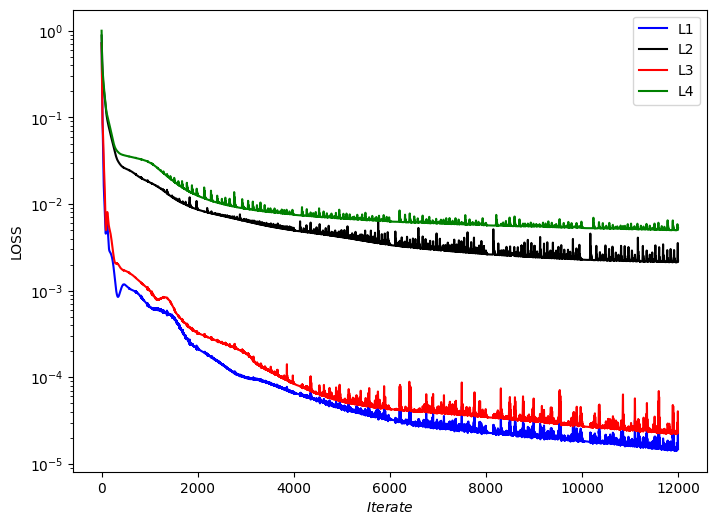

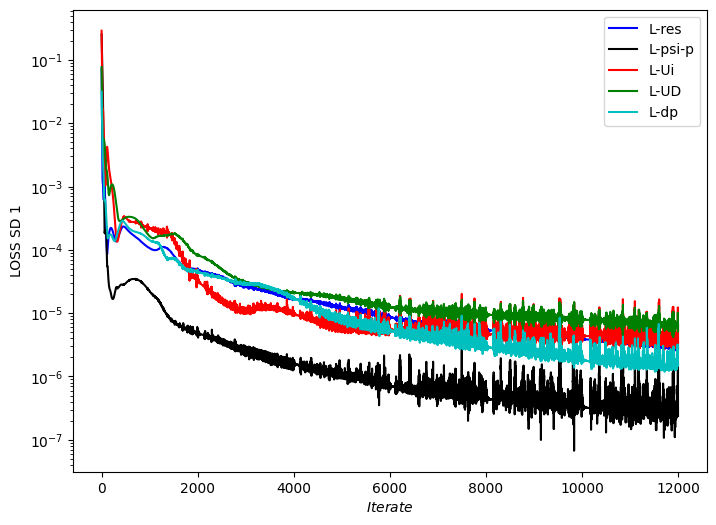

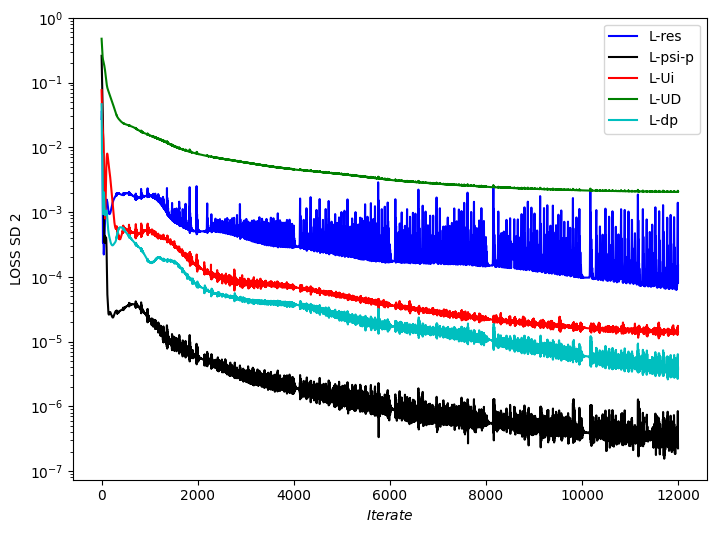

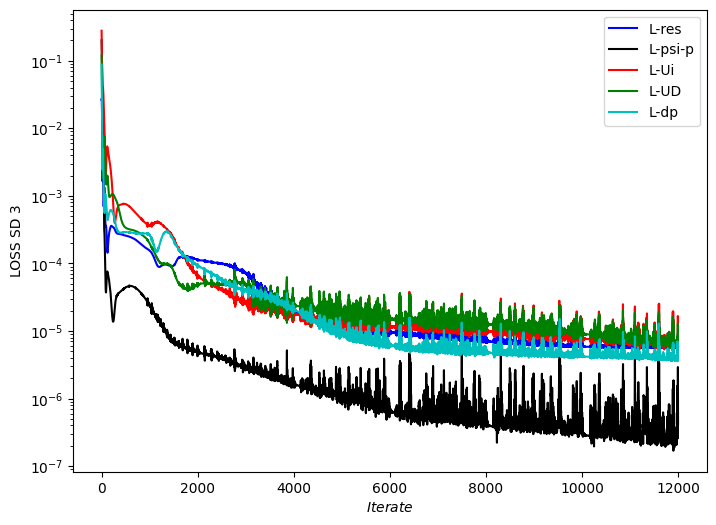

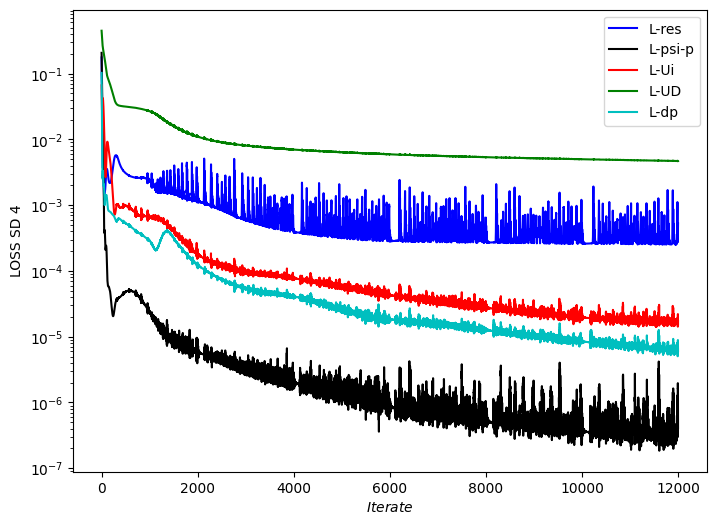

In [48]:
#Loss Hist Plot
import numpy
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize=(18,6))
ax = fig2.add_subplot(1,2,1)
ax.semilogy(range(len(hist1)), hist1,'k-', c = 'b', label = 'L1')
ax.semilogy(range(len(hist2)), hist2,'k-', label = 'L2')
ax.semilogy(range(len(hist3)), hist3,'k-', c = 'r', label = 'L3')
ax.semilogy(range(len(hist2)), hist4,'k-', c = 'g', label = 'L4')

ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS');
ax.legend(loc='upper right', frameon=True)


'''if Mode_1 in ['M2']:
  ax = fig2.add_subplot(1,2,2)
  X_Axis = np.linspace(0, N_ep, num=int((N_ep/10)+1)) #adjust x-axis for APC values
  APC_log_e2 = numpy.array(adaptive_constant_bcs_log_e2) #turn float into int
  APC_log_e4 = numpy.array(adaptive_constant_bcs_log_e4) #turn float into int
  ax.plot(X_Axis, APC_log_e2, label = 'e2')
  ax.plot(X_Axis, APC_log_e4, label = 'e4')
  ax.set_xlabel('$Iterate$')
  ax.set_ylabel('Adaptive Penalization Coefficient')
  ax.legend(loc='upper right', frameon=True)'''
# loss hist e1
fig2_1 = plt.figure(figsize=(18,6))
ax = fig2_1.add_subplot(1,2,1)
ax.semilogy(range(len(histe1_1)), histe1_1,'k-', c = 'b', label = 'L-res')
ax.semilogy(range(len(histe1_2)), histe1_2,'k-', label = 'L-psi-p')
ax.semilogy(range(len(histe1_3)), histe1_3,'k-', c = 'r', label = 'L-Ui')
ax.semilogy(range(len(histe1_4)), histe1_4,'k-', c = 'g', label = 'L-UD')
ax.semilogy(range(len(histe1_5)), histe1_5,'k-', c = 'c', label = 'L-dp')
ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS SD 1');
ax.legend(loc='upper right', frameon=True)
plt.savefig(f'lost hist SD 1', bbox_inches='tight', dpi=300)
'''if Mode_1 in ['M2']:
  ax = fig2_1.add_subplot(1,2,2)
  X_Axis = np.linspace(0, N_ep, num=int((N_ep/10)+1)) #adjust x-axis for APC values
  APC_res_loge1 = numpy.array(APC_res_log[0]) #turn float into int
  APC_psi_p_loge1 = numpy.array(APC_psi_p_log[0]) #turn float into int
  APC_U_i_loge1 = numpy.array(APC_U_i_log[0])
  APC_U_D_loge1 = numpy.array(APC_U_D_log[0])
  APC_dp_loge1 = numpy.array(APC_dp_log[0])
  ax.plot(X_Axis, APC_res_loge1, label = 'APC res')
  ax.plot(X_Axis, APC_psi_p_loge1, label = 'APC psi-p')
  ax.plot(X_Axis, APC_U_i_loge1, label = 'APC Ui')
  ax.plot(X_Axis, APC_U_D_loge1, label = 'APC UD')
  ax.plot(X_Axis, APC_dp_loge1, label = 'APC dp')

  ax.set_xlabel('$Iterate$')
  ax.set_ylabel('LOSS e1');
  ax.legend(loc='upper right', frameon=True)'''

# loss hist e2
fig2_1 = plt.figure(figsize=(18,6))
ax = fig2_1.add_subplot(1,2,1)
ax.semilogy(range(len(histe2_1)), histe2_1,'k-', c = 'b', label = 'L-res')
ax.semilogy(range(len(histe2_2)), histe2_2,'k-', label = 'L-psi-p')
ax.semilogy(range(len(histe2_3)), histe2_3,'k-', c = 'r', label = 'L-Ui')
ax.semilogy(range(len(histe2_4)), histe2_4,'k-', c = 'g', label = 'L-UD')
ax.semilogy(range(len(histe2_5)), histe2_5,'k-', c = 'c', label = 'L-dp')

ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS SD 2');
ax.legend(loc='upper right', frameon=True)
plt.savefig(f'lost hist SD 2', bbox_inches='tight', dpi=300)

# loss hist e3
fig2_1 = plt.figure(figsize=(18,6))
ax = fig2_1.add_subplot(1,2,1)
ax.semilogy(range(len(histe3_1)), histe3_1,'k-', c = 'b', label = 'L-res')
ax.semilogy(range(len(histe3_2)), histe3_2,'k-', label = 'L-psi-p')
ax.semilogy(range(len(histe3_3)), histe3_3,'k-', c = 'r', label = 'L-Ui')
ax.semilogy(range(len(histe3_4)), histe3_4,'k-', c = 'g', label = 'L-UD')
ax.semilogy(range(len(histe3_5)), histe3_5,'k-', c = 'c', label = 'L-dp')

ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS SD 3');
ax.legend(loc='upper right', frameon=True)
plt.savefig(f'lost hist SD 3', bbox_inches='tight', dpi=300)

# loss hist e4
fig2_1 = plt.figure(figsize=(18,6))
ax = fig2_1.add_subplot(1,2,1)
ax.semilogy(range(len(histe4_1)), histe4_1,'k-', c = 'b', label = 'L-res')
ax.semilogy(range(len(histe4_2)), histe4_2,'k-', label = 'L-psi-p')
ax.semilogy(range(len(histe4_3)), histe4_3,'k-', c = 'r', label = 'L-Ui')
ax.semilogy(range(len(histe4_4)), histe4_4,'k-', c = 'g', label = 'L-UD')
ax.semilogy(range(len(histe4_5)), histe4_5,'k-', c = 'c', label = 'L-dp')

ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS SD 4');
ax.legend(loc='upper right', frameon=True)
plt.savefig(f'lost hist SD 4', bbox_inches='tight', dpi=300)


l2 error1: 3.86e-02


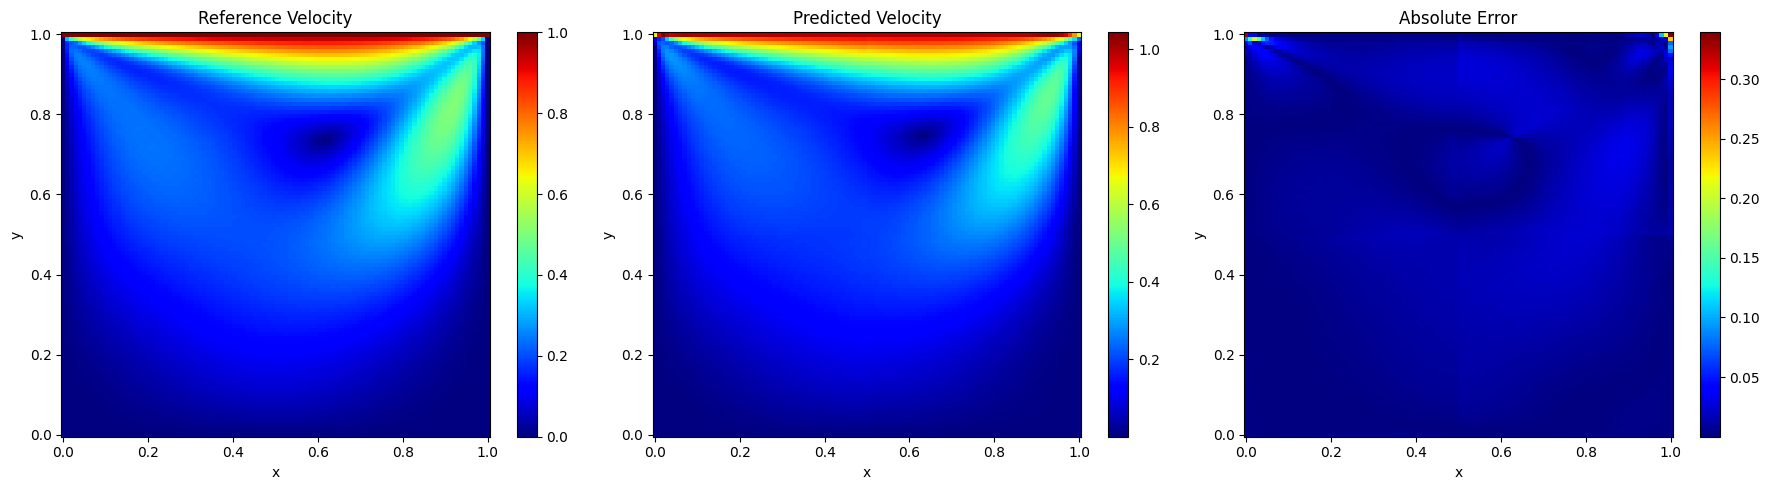

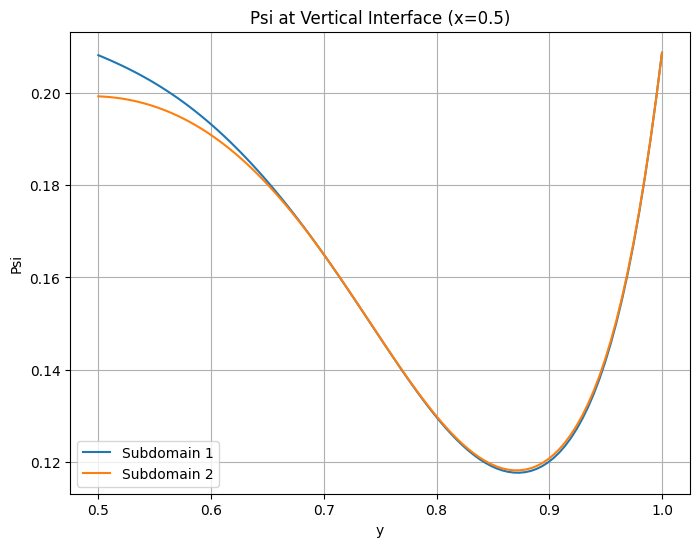

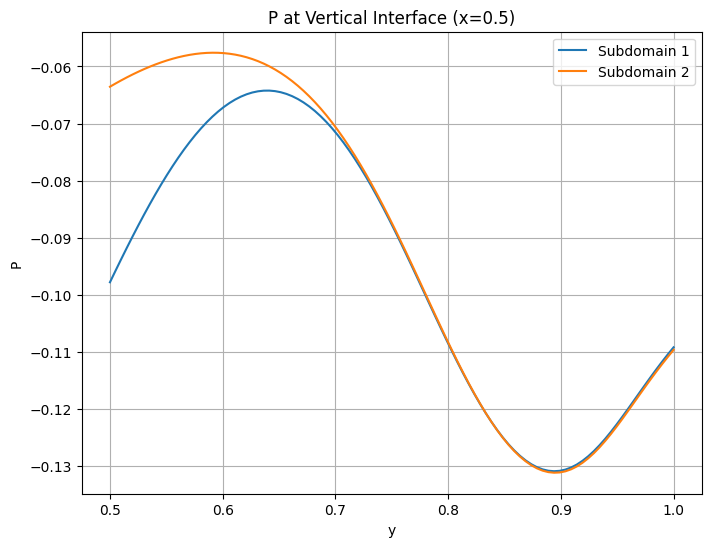

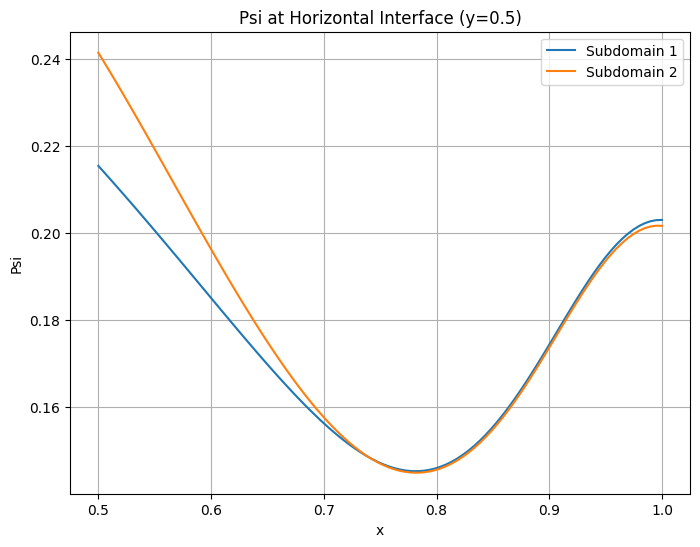

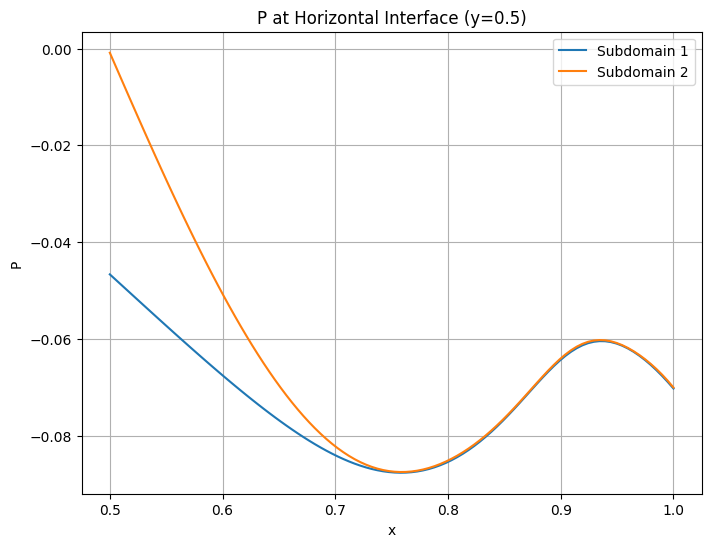

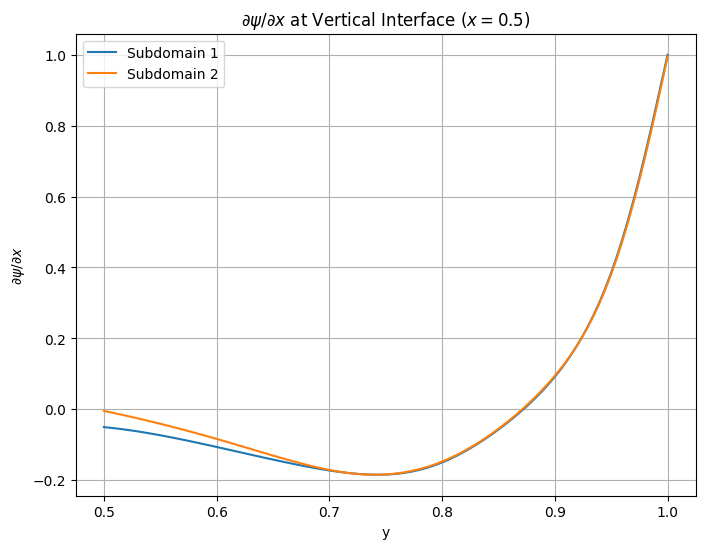

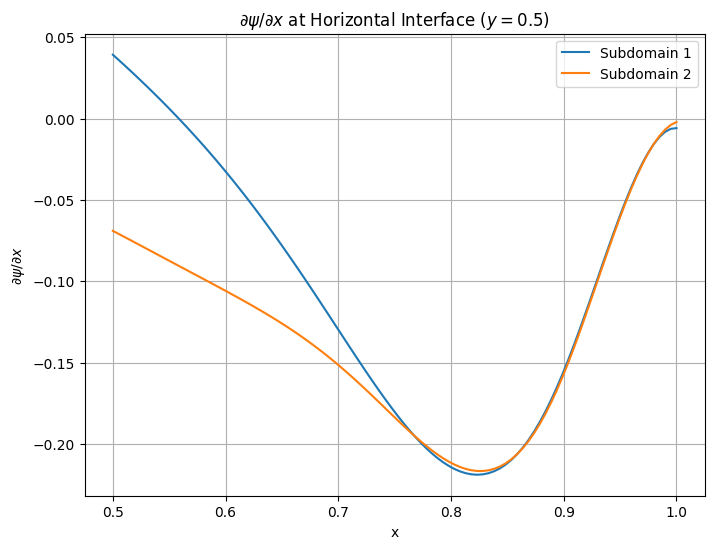

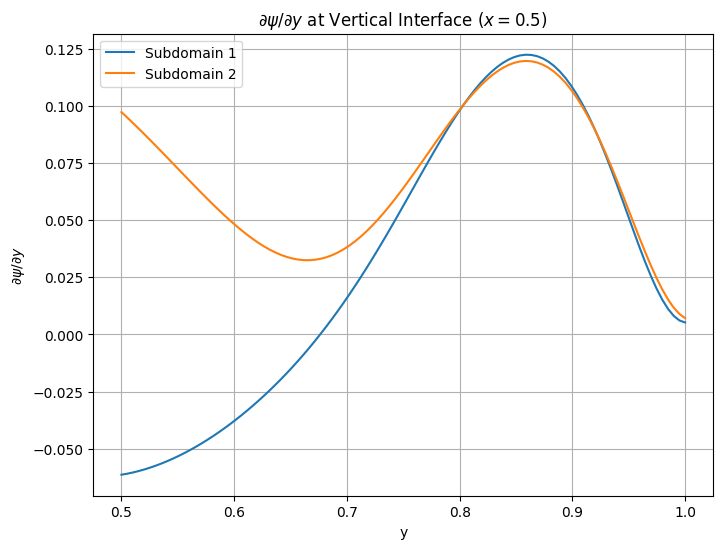

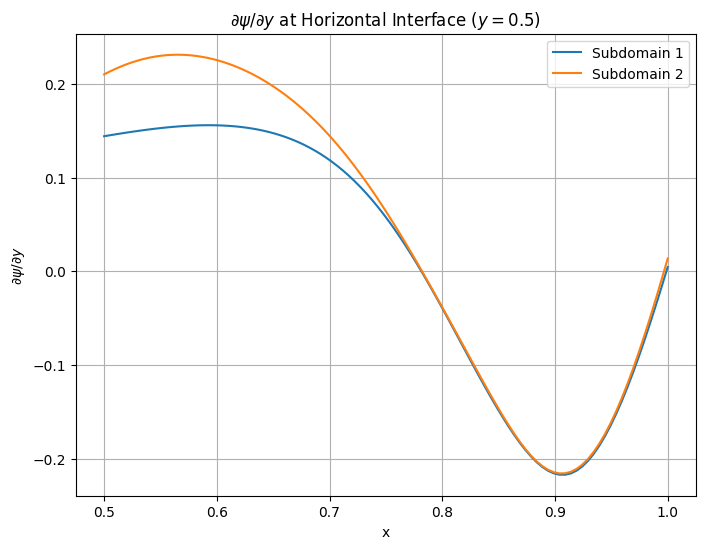

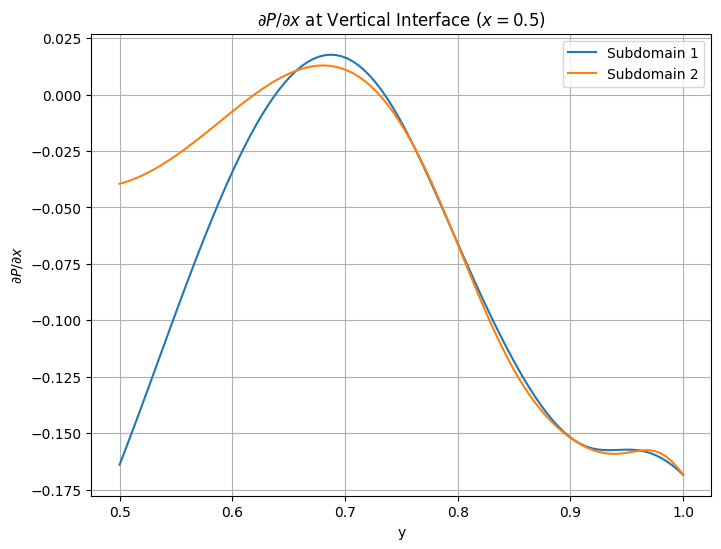

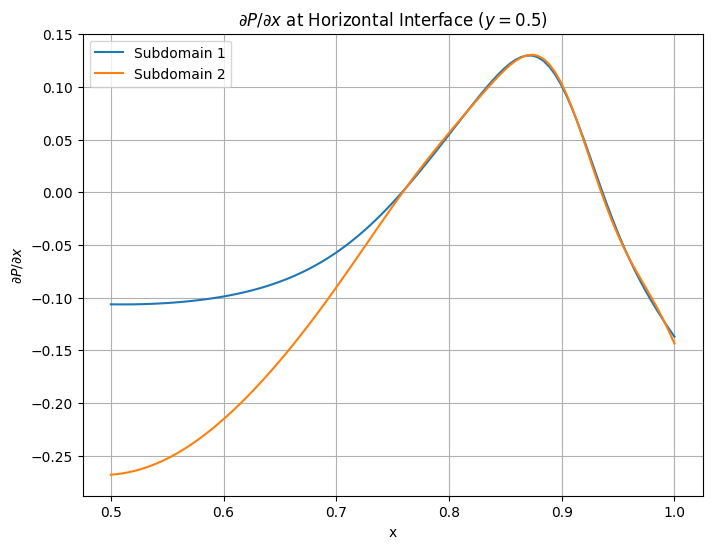

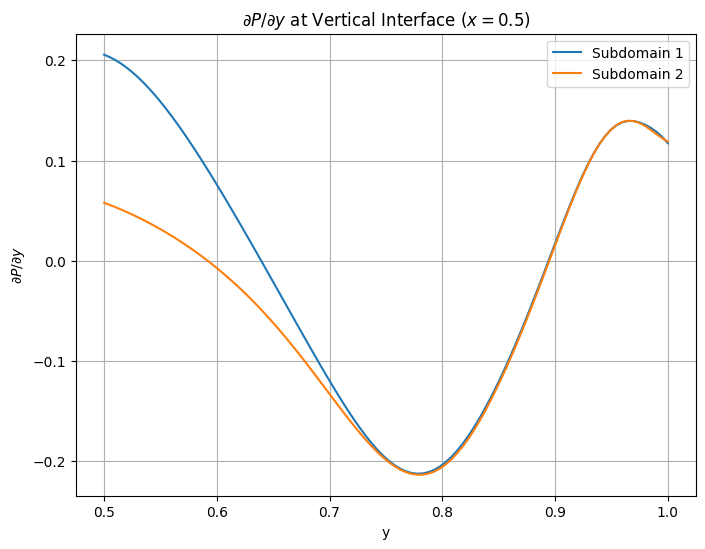

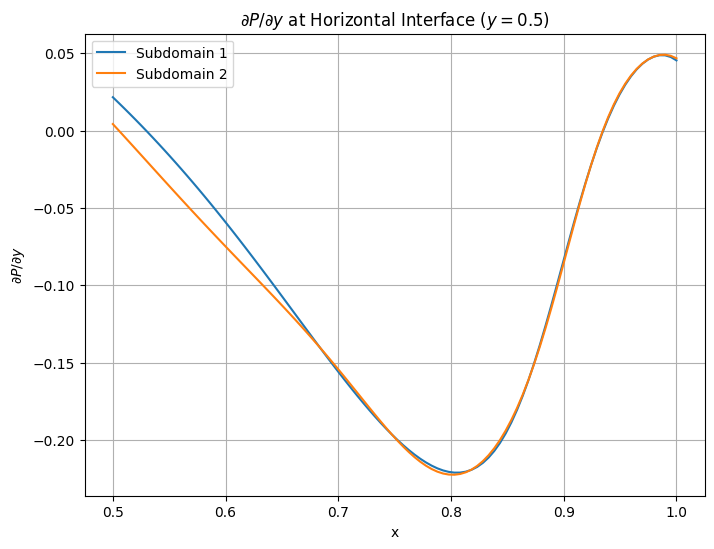

In [49]:
from scipy.interpolate import griddata
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

nx = 100  # num of test sampples
ny = 100  # num of test sampples
x = np.linspace(0.0, 1.0, nx)
y = np.linspace(0.0, 1.0, ny)
X, Y = np.meshgrid(x, y)
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

X1, Y1, X2, Y2, X3, Y3, X4, Y4 = [], [], [], [], [], [], [], []
for i in range(len(X_star)):
  x, y = X_star[i, 0:1], X_star[i,1:2]
  if  0.0 <= x <= 0.5 and 0.0 <= y <= 0.5:
    X1.append(x)
    Y1.append(y)
  elif 0.0 <= x <= 0.5 and 0.5 <= y <= 1.0:
    X2.append(x)
    Y2.append(y)
  elif 0.5 <= x <= 1.0 and 0.0 <= y <= 0.5:
    X3.append(x)
    Y3.append(y)
  elif 0.5 <= x <= 1.0 and 0.5 <= y <= 1.0:
    X4.append(x)
    Y4.append(y)

XS1 = np.hstack((X1, Y1))
XS2 = np.hstack((X2, Y2))
XS3 = np.hstack((X3, Y3))
XS4 = np.hstack((X4, Y4))

#x_tot = np.concatenate([X1, X2, X3, X4])
#y_tot = np.concatenate([Y1, Y2, Y3, Y4])

# compute (u, v)
def uv_grid(X, w, b, w1, b1, w2, b2):
  X = tf.convert_to_tensor(X, dtype = tf.float32)
  with tf.GradientTape(persistent = True) as g:
    x, y = X[:, 0:1], X[:,1:2]
    g.watch(x)
    g.watch(y)
    psi_p = forward_pass(tf.stack([x[:,0], y[:,0]], axis=-1), w, b, w1, b1, w2, b2)
    psi = psi_p[..., 0, tf.newaxis]
    p = psi_p[..., 1, tf.newaxis]
  u =  g.gradient(psi, y)
  v = -g.gradient(psi, x)
  p_x = g.gradient(p, x)
  p_y = g.gradient(p, y)
  del g
  return u.numpy(), v.numpy(), psi.numpy(), p.numpy(), p_x.numpy(), p_y.numpy()



u1, v1, psi1, p1, px1, py1 = uv_grid(XS1, weights1, biases1, encoder_weights_1[0], encoder_biases_1[0], encoder_weights_2[0], encoder_biases_2[0])
u2, v2, psi2, p2, px2, py2 = uv_grid(XS2, weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])
u3, v3, psi3, p3, px3, py3 = uv_grid(XS3, weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])
u4, v4, psi4, p4, px4, py4 = uv_grid(XS4, weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])

x_tot = np.concatenate([X1, X2, X3, X4])
y_tot = np.concatenate([Y1, Y2, Y3, Y4])
#Xt, Yt = np.meshgrid(x_tot, y_tot)

u_tot = np.concatenate([u1, u2, u3, u4])
v_tot = np.concatenate([v1, v2, v3, v4])
psi_tot = np.concatenate([psi1, psi2, psi3, psi4])
p_tot = np.concatenate([p1, p2, p3, p4])
U_tot = np.sqrt(u_tot**2 + v_tot**2)
X_starz = []
X_starZ = np.concatenate([XS1, XS2, XS3, XS4])



U_interpolated = griddata(X_starZ, U_tot.flatten(), (X, Y), method='cubic')
#U_interpolated = griddata((x_tot.flatten(), y_tot.flatten()), U_tot.flatten(), (Xt, Yt), method='cubic')
#U_interpolated2 = griddata(X_starZ2, U_tot2.flatten(), (X, Y), method='cubic')
psi_grid = griddata(X_starZ, psi_tot.flatten(), (X, Y), method='cubic')
p_grid = griddata(X_starZ, p_tot.flatten(), (X, Y), method='cubic')

# Sort the rows of X_starZ by the first column (x) and then the second column (y)
idx = np.lexsort((X_starZ[:,0], X_starZ[:,1]))
# Rearrange the rows of X_starZ using the sorted indices
X_starZ2 = X_starZ[idx]
velocity= U_tot[idx]
psi_tot2 = psi_tot[idx]
p_tot2 = p_tot[idx]
velocity_app = griddata(X_starZ2, velocity.flatten(), (X, Y), method='cubic')
psi_grid2 = griddata(X_starZ2, psi_tot2.flatten(), (X, Y), method='cubic')
p_grid2 = griddata(X_starZ2, p_tot2.flatten(), (X, Y), method='cubic')
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Reference
u_ref= np.genfromtxt("reference_u.csv", delimiter=',')
v_ref= np.genfromtxt("reference_v.csv", delimiter=',')
velocity_ref = np.sqrt(u_ref**2 + v_ref**2)

# Relative error
vel_ref = velocity_ref.T
error1 = np.linalg.norm(velocity_app - velocity_ref.T, 2) / np.linalg.norm(velocity_ref, 2)
print('l2 error1: {:.2e}'.format(error1))
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Plots
# Reference solution & Prediceted solution
# Velocity Magnitude
fig_3 = plt.figure(1, figsize=(18, 5))
fig_3.add_subplot(1, 3, 1)
plt.pcolor(X.T, Y.T, velocity_ref, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reference Velocity')

fig_3.add_subplot(1, 3, 2)
plt.pcolor(X, Y, velocity_app, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Velocity')
plt.tight_layout()

fig_3.add_subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(velocity_app - velocity_ref.T), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.savefig(f'Velocity Cuntor', bbox_inches='tight', dpi=300)
plt.show()
################################################################################ NEW
# Vertical interface at x = 0.5
x_vertical = 0.5

# Compute psi and p at the vertical interface for Subdomain 2 (Top Left)
u_vertical1, v_vertical1, psi_vertical1, p_vertical1, px_vertical1, py_vertical1 = uv_grid(np.array([[x_vertical, y] for y in np.linspace(0, 1, ny)]), weights2, biases2, encoder_weights_1[1], encoder_biases_1[1], encoder_weights_2[1], encoder_biases_2[1])

# Compute psi and p at the vertical interface for Subdomain 4 (Top Right)
u_vertical2, v_vertical2, psi_vertical2, p_vertical2, px_vertical2, py_vertical2 = uv_grid(np.array([[x_vertical, y] for y in np.linspace(0, 1, ny)]), weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])

# Horizontal interface at y = 0.5
y_horizontal = 0.5

# Compute psi and p at the horizontal interface for Subdomain 3 (Bottom Right)
u_horizontal1, v_horizontal1, psi_horizontal1, p_horizontal1, px_horizontal1, py_horizontal1 = uv_grid(np.array([[x, y_horizontal] for x in np.linspace(0, 1, nx)]), weights3, biases3, encoder_weights_1[2], encoder_biases_1[2], encoder_weights_2[2], encoder_biases_2[2])

# Compute psi and p at the horizontal interface for Subdomain 4 (Top Right)
u_horizontal2, v_horizontal2, psi_horizontal2, p_horizontal2, px_horizontal2, py_horizontal2 = uv_grid(np.array([[x, y_horizontal] for x in np.linspace(0, 1, nx)]), weights4, biases4, encoder_weights_1[3], encoder_biases_1[3], encoder_weights_2[3], encoder_biases_2[3])


# Plotting psi at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), psi_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), psi_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('Psi')
plt.title('Psi at Vertical Interface (x=0.5)')
plt.legend()
plt.grid(True)
plt.savefig(f'Psi at Vertical Interface', bbox_inches='tight', dpi=600)
plt.show()

# Plotting p at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), p_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), p_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('P')
plt.title('P at Vertical Interface (x=0.5)')
plt.legend()
plt.grid(True)
plt.savefig(f'P at Vertical Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting psi at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), psi_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), psi_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('Psi')
plt.title('Psi at Horizontal Interface (y=0.5)')
plt.legend()
plt.grid(True)
plt.savefig(f'Psi at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting p at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), p_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), p_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('P')
plt.title('P at Horizontal Interface (y=0.5)')
plt.legend()
plt.grid(True)
plt.savefig(f'P at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(\psi) at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), u_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), u_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('$\partial \psi / \partial x$')
plt.title('$\partial \psi / \partial x$ at Vertical Interface ($x=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'u at Vertical Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(\psi) at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), u_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), u_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('$\partial \psi / \partial x$')
plt.title('$\partial \psi / \partial x$ at Horizontal Interface ($y=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'u at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()

# Similarly for other plots:
# Plotting \nabla(v) at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), v_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), v_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('$\partial \psi / \partial y$')
plt.title('$\partial \psi / \partial y$ at Vertical Interface ($x=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'v at Vertical Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(v) at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), v_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), v_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('$\partial \psi / \partial y$')
plt.title('$\partial \psi / \partial y$ at Horizontal Interface ($y=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'v at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(p_x) at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), px_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), px_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('$\partial P / \partial x$')
plt.title('$\partial P / \partial x$ at Vertical Interface ($x=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'px at Vertical Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(p_x) at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), px_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), px_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('$\partial P / \partial x$')
plt.title('$\partial P / \partial x$ at Horizontal Interface ($y=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'px at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(p_y) at the vertical interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, ny), py_vertical1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, ny), py_vertical2, label='Subdomain 2')
plt.xlabel('y')
plt.ylabel('$\partial P / \partial y$')
plt.title('$\partial P / \partial y$ at Vertical Interface ($x=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'py at Vertical Interface', bbox_inches='tight', dpi=300)
plt.show()

# Plotting \nabla(p_y) at the horizontal interface
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, 1, nx), py_horizontal1, label='Subdomain 1')
plt.plot(np.linspace(0.5, 1, nx), py_horizontal2, label='Subdomain 2')
plt.xlabel('x')
plt.ylabel('$\partial P / \partial y$')
plt.title('$\partial P / \partial y$ at Horizontal Interface ($y=0.5$)')
plt.legend()
plt.grid(True)
plt.savefig(f'py at Horizontal Interface', bbox_inches='tight', dpi=300)
plt.show()


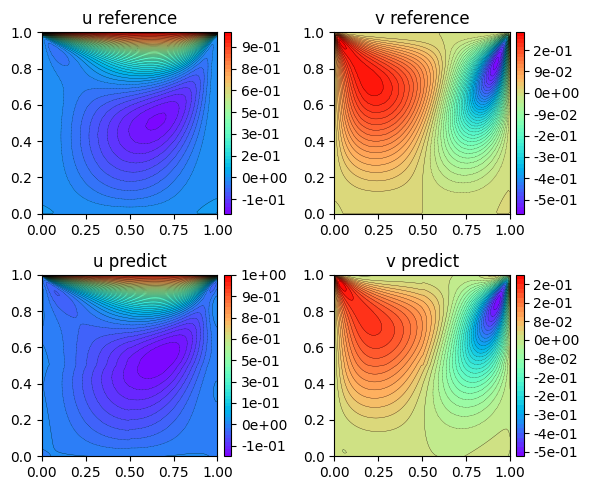

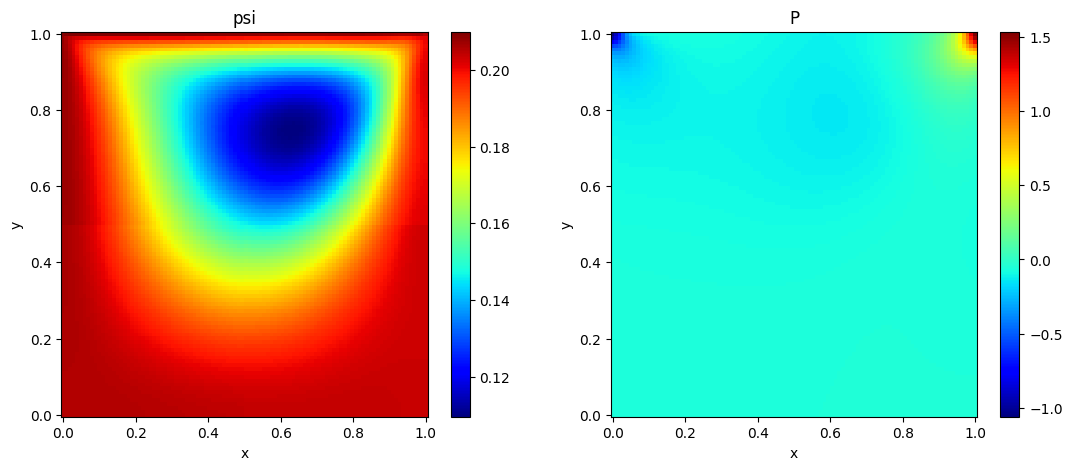

In [50]:
#@title Results II
from matplotlib.gridspec import GridSpec
u_tot2 = u_tot.reshape(X.shape)
v_tot2 = v_tot.reshape(Y.shape)
# Velocity: x-dir & y-dir
u_app_grid = griddata(X_starZ, u_tot2.flatten(), (X, Y), method='cubic')
v_app_grid = griddata(X_starZ, v_tot2.flatten(), (X, Y), method='cubic')



def contour(grid, x, y, z, title, levels=50):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # plot a contour
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels)
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')


fig_4 = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 2)
contour(gs[0, 0], X.T, Y.T, u_ref, 'u reference')
contour(gs[0, 1], X.T, Y.T, v_ref, 'v reference')
contour(gs[1, 0], X, Y, u_app_grid, 'u predict')
contour(gs[1, 1], X, Y, v_app_grid, 'v predict')
plt.tight_layout()
plt.show()

#p_plot = p.numpy()
p_plot = p_tot2.reshape((100,100))

#psi_plot = psi.numpy()
psi_plot = psi_tot2.reshape((100,100))

fig_5 = plt.figure(1, figsize=(13, 5))
fig_5.add_subplot(1, 2, 1)
plt.pcolor(X, Y, psi_plot, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('psi')
plt.savefig(f'psi plot', bbox_inches='tight', dpi=300)

fig_5.add_subplot(1, 2, 2)
plt.pcolor(X, Y, p_plot, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('P')
plt.savefig(f'p plot', bbox_inches='tight', dpi=300)
plt.show()

